In [1]:
# copy from mnist of exmaple in chainer v4.0
from __future__ import print_function

import argparse

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions


In [2]:
import os
import numpy as np

In [3]:
train, test = chainer.datasets.get_mnist()

In [4]:
index_0and1 = np.logical_or(train._datasets[1] == 0, train._datasets[1] == 1)
index = np.logical_or(index_0and1, train._datasets[1] == 2)
datas = train[index]

print(len(datas[1]), len(train._datasets[1]))

train._datasets = datas
train._length = len(datas[1])

index_0and1 = np.logical_or(test._datasets[1] == 0, test._datasets[1] == 1)
index = np.logical_or(index_0and1, test._datasets[1] == 2)

datas = test[index]

print(len(datas[1]), len(test._datasets[1]))

test._datasets = datas
test._length = len(datas[1])

18623 60000
3147 10000


In [5]:
train[:2], test[:2]

([(array([0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        

In [6]:
xs = [1, 2, 3]
len(xs), 2 > len(xs), 3 > len(xs)

(3, False, False)

In [20]:
# Network definition
BATCH_SIZE = 100
from chainer import ChainList, Chain
class SepLink(ChainList):
    def __init__(self, n_separate, link=L.Linear, **kwargs):
        """
            n_separate: 共用変数込みの分割サイズ
            共用, 特定クラス１, 特定クラス２, ...の順番
        """
        super(SepLink, self).__init__()
        self.n_separate = n_separate
        with self.init_scope():
            for i in range(self.n_separate):
                self.add_link(link(**kwargs))
    
    def __call__(self, xs):
        """
            xs: list of variables. eg. [common, specific class 1, specific class 2, ...]
        """
        assert len(xs) > 0
        common_x = xs[0]
        common_y = self[0](common_x)
        ys = [common_y]
        for i in range(1, self.n_separate):
            if i > len(xs) -1:
                x = common_x
            else:
                x = F.concat((common_x, xs[i]), axis=1)
            y = self[i](x)
            ys.append(y)
#         if self.input_sep_flag:
#             act_var = []
#             for i in range(self.n_separate):
#                 var = F.expand_dims(x.reshape(BATCH_SIZE, self.n_separate, -1)[:, i, :], 1)
#                 act_var.append(self[i](var))
#         else:
#             act_var = []
#             for i in range(self.n_separate):
#                 act_var.append(self[i](x))
#         res = F.concat(act_var, axis=1)
        return ys

class SepCLF(ChainList):
    def __init__(self, n_specific=2):
        super(SepCLF, self).__init__()
        self.n_specific = n_specific
        with self.init_scope():
            for i in range(self.n_specific):
                self.add_link(L.Linear(None, 1))
    
    def __call__(self, xs):
        assert 1 < len(xs)
        ys = []
        # 共用の結果は抜く
        for i, x in enumerate(xs[1:]):
            h = F.concat([xs[0], x], axis=1)
            ys.append(self[i](h))
        return ys

class SepMLP(Chain):

    def __init__(self, in_size, out_size, n_specific=2):
        super(SepMLP, self).__init__()
        with self.init_scope():
            self.l1 = SepLink(n_separate=n_specific+1, link=L.Linear, in_size=in_size, out_size=out_size)
#             self.l2 = SepLink(n_separate=n_specific+1, link=L.Linear, in_size=None, out_size=out_size)
#             self.l3 = SepLink(n_separate=n_specific+1, link=L.Linear, in_size=None, out_size=out_size)
            self.out = SepCLF(n_specific)
        
#         with self.init_scope():
#             if 0 in separate_layer:
#                 self.l1 = SepLinear(None, n_units//n_sep, n_sep, False)
#             else:
#                 self.l1 = L.Linear(None, n_units)
            
#             if 1 in separate_layer:
#                 if 0 in separate_layer:
#                     flag = True
#                 else:
#                     flag = False
#                 self.l2 = SepLinear(None, n_units//n_sep, n_sep, flag)
#             else:
#                 self.l2 = L.Linear(None, n_units)

#             if 2 in separate_layer:
#                 if 1 in separate_layer:
#                     flag = True
#                 else:
#                     flag = False
#                 self.l3 = SepLinear(None, n_out//n_sep, n_sep, flag)
#             else:
#                 self.l3 = L.Linear(None, n_out)

    def __call__(self, x):
        if not isinstance(x, list):
            x = [x]
#         print('x', len(x), list(map(lambda x:x.shape, x)))
        h1 = list(map(F.relu, self.l1(x)))
#         print('h1', len(h1), list(map(lambda x:x.shape, h1)))
#         h2 = list(map(F.relu, self.l2(h1)))
#         print('h2', len(h2), list(map(lambda x:x.shape, h2)))
        outs = self.out(h1)
#         print('outs', len(outs), list(map(lambda x:x.shape, outs)))
        out = F.concat(outs, axis=1)
#         print('out', out.shape)
        return out

class MLP(Chain):
    def __init__(self, in_size, out_size, n_specific=2):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, out_size)
#             self.l2 = L.Linear(None, out_size)
            self.out = L.Linear(None, n_specific)
    
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
#         h2 = F.relu(self.l2(h1))
        out = self.out(h1)
        return out

In [26]:
def main():
#     parser = argparse.ArgumentParser(description='Chainer example: MNIST')
#     parser.add_argument('--batchsize', '-b', type=int, default=100,
#                         help='Number of images in each mini-batch')
#     parser.add_argument('--epoch', '-e', type=int, default=20,
#                         help='Number of sweeps over the dataset to train')
#     parser.add_argument('--frequency', '-f', type=int, default=-1,
#                         help='Frequency of taking a snapshot')
#     parser.add_argument('--gpu', '-g', type=int, default=-1,
#                         help='GPU ID (negative value indicates CPU)')
#     parser.add_argument('--out', '-o', default='result',
#                         help='Directory to output the result')
#     parser.add_argument('--resume', '-r', default='',
#                         help='Resume the training from snapshot')
#     parser.add_argument('--unit', '-u', type=int, default=1000,
#                         help='Number of units')
#     args = parser.parse_args()
    args_batchsize = BATCH_SIZE
    args_epoch = 50
    args_frequency = -1
    args_gpu = 0
    args_out = 'result_new_3class'
    args_unit = int(3**2)
    vanilla_train = True
    
    if not os.path.exists(args_out):
        os.makedirs(args_out)
    print('GPU: {}'.format(args_gpu))
    print('# unit: {}'.format(args_unit))
    print('# Minibatch-size: {}'.format(args_batchsize))
    print('# epoch: {}'.format(args_epoch))
    print('')

    # Set up a neural network to train
    # Classifier reports softmax cross entropy loss and accuracy at every
    # iteration, which will be used by the PrintReport extension below.
    in_size = None
    out_size = args_unit
#     model = L.Classifier(SepMLP(in_size, out_size))
    model = L.Classifier(MLP(in_size, int(out_size*4), n_specific=3))
    if args_gpu >= 0:
        # Make a specified GPU current
        chainer.backends.cuda.get_device_from_id(args_gpu).use()
        model.to_gpu()  # Copy the model to the GPU

    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    # Load the MNIST dataset
#     train, test = chainer.datasets.get_mnist()

    train_iter = chainer.iterators.SerialIterator(train, args_batchsize)
    test_iter = chainer.iterators.SerialIterator(test, args_batchsize,
                                                 repeat=False, shuffle=False)

    # Set up a trainer
    updater = training.updaters.StandardUpdater(
        train_iter, optimizer, device=args_gpu)
    trainer = training.Trainer(updater, (args_epoch, 'epoch'), out=args_out)

    # Evaluate the model with the test dataset for each epoch
    trainer.extend(extensions.Evaluator(test_iter, model, device=args_gpu))

    # Dump a computational graph from 'loss' variable at the first iteration
    # The "main" refers to the target link of the "main" optimizer.
    trainer.extend(extensions.dump_graph('main/loss'))

    # Take a snapshot for each specified epoch
    frequency = args_epoch if args_frequency == -1 else max(1, args_frequency)
    trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

    trainer.extend(extensions.LogReport())
    trainer.extend(
        extensions.PlotReport(['main/loss', 'validation/main/loss'],
                              'epoch', file_name='loss.png'))
    trainer.extend(
        extensions.PlotReport(
            ['main/accuracy', 'validation/main/accuracy'],
            'epoch', file_name='accuracy.png'))

    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

    trainer.extend(extensions.ProgressBar())


    # Run the training
    if vanilla_train:
        print('training vanilla')
        chainer.serializers.save_npz(args_out +'/vanilla-base.model', model)
        trainer.run()
        chainer.serializers.save_npz(args_out +'/vanilla.model', model)

    args_out = 'sep_'+ args_out
    if not os.path.exists(args_out):
        os.makedirs(args_out)
    model = L.Classifier(SepMLP(in_size, out_size, n_specific=3))
    print(model.predictor.l1.n_separate)
    if args_gpu >= 0:
        # Make a specified GPU current
        chainer.backends.cuda.get_device_from_id(args_gpu).use()
        model.to_gpu()  # Copy the model to the GPU

    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    # Load the MNIST dataset
#     train, test = chainer.datasets.get_mnist()

    train_iter = chainer.iterators.SerialIterator(train, args_batchsize)
    test_iter = chainer.iterators.SerialIterator(test, args_batchsize,
                                                 repeat=False, shuffle=False)

    # Set up a trainer
    updater = training.updaters.StandardUpdater(
        train_iter, optimizer, device=args_gpu)
    trainer = training.Trainer(updater, (args_epoch, 'epoch'), out=args_out)

    # Evaluate the model with the test dataset for each epoch
    trainer.extend(extensions.Evaluator(test_iter, model, device=args_gpu))

    # Dump a computational graph from 'loss' variable at the first iteration
    # The "main" refers to the target link of the "main" optimizer.
    trainer.extend(extensions.dump_graph('main/loss'))

    # Take a snapshot for each specified epoch
    frequency = args_epoch if args_frequency == -1 else max(1, args_frequency)
    trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

    trainer.extend(extensions.LogReport())
    trainer.extend(
        extensions.PlotReport(['main/loss', 'validation/main/loss'],
                              'epoch', file_name='loss.png'))
    trainer.extend(
        extensions.PlotReport(
            ['main/accuracy', 'validation/main/accuracy'],
            'epoch', file_name='accuracy.png'))

    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

    trainer.extend(extensions.ProgressBar())


    # Run the training
    print('training two separated model')
    chainer.serializers.save_npz(args_out +'/sep-base.model', model)
    trainer.run()
    chainer.serializers.save_npz(args_out +'/sep.model', model)

In [27]:
main()

GPU: 0
# unit: 9
# Minibatch-size: 100
# epoch: 50

training vanilla
epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
     total [..................................................]  1.07%
this epoch [##########################........................] 53.70%
       100 iter, 0 epoch / 50 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
1           0.126568    0.0417483             0.966417       0.989023                  0.665231      
     total [#.................................................]  2.15%
this epoch [###...............................................]  7.39%
       200 iter, 1 epoch / 50 epochs
    176.59 iters/sec. Estimated time to finish: 0:00:51.596179.
     total [#.................................................]  3.22%
this epoch [##############################....................] 61.09%
       300 iter, 1 epoch / 50 epochs
    229.25 iters/sec. Estimated time to finish: 0:00:39.309024.
2      

15          0.00296557  0.0144569             0.99957        0.99375                   12.611        
     total [###############...................................] 30.07%
this epoch [#.................................................]  3.52%
      2800 iter, 15 epoch / 50 epochs
     215.8 iters/sec. Estimated time to finish: 0:00:30.174043.
     total [###############...................................] 31.14%
this epoch [############################......................] 57.21%
      2900 iter, 15 epoch / 50 epochs
    218.59 iters/sec. Estimated time to finish: 0:00:29.331398.
16          0.00266642  0.0147269             0.999624       0.994375                  13.438        
     total [################..................................] 32.22%
this epoch [#####.............................................] 10.91%
      3000 iter, 16 epoch / 50 epochs
    215.76 iters/sec. Estimated time to finish: 0:00:29.252848.
     total [################..................................] 

29          0.000344638  0.0167522             1              0.994375                  24.3835       
     total [#############################.....................] 59.07%
this epoch [##########################........................] 53.34%
      5500 iter, 29 epoch / 50 epochs
    219.89 iters/sec. Estimated time to finish: 0:00:17.333530.
30          0.000304995  0.0168376             1              0.994687                  25.2065       
     total [##############################....................] 60.14%
this epoch [###...............................................]  7.03%
      5600 iter, 30 epoch / 50 epochs
    218.95 iters/sec. Estimated time to finish: 0:00:16.951235.
     total [##############################....................] 61.21%
this epoch [##############################....................] 60.73%
      5700 iter, 30 epoch / 50 epochs
    220.32 iters/sec. Estimated time to finish: 0:00:16.392067.
31          0.000280379  0.0171323             1              

44          0.000120685  0.0178114             1              0.995                     36.9997       
     total [############################################......] 88.06%
this epoch [#.................................................]  3.16%
      8200 iter, 44 epoch / 50 epochs
    219.48 iters/sec. Estimated time to finish: 0:00:05.064230.
     total [############################################......] 89.14%
this epoch [############################......................] 56.85%
      8300 iter, 44 epoch / 50 epochs
    220.41 iters/sec. Estimated time to finish: 0:00:04.589176.
45          0.000108787  0.0180459             1              0.995                     37.8365       
     total [#############################################.....] 90.21%
this epoch [#####.............................................] 10.55%
      8400 iter, 45 epoch / 50 epochs
     219.8 iters/sec. Estimated time to finish: 0:00:04.146991.
     total [#############################################.....

     total [########..........................................] 17.18%
this epoch [#############################.....................] 59.15%
      1600 iter, 8 epoch / 50 epochs
    113.51 iters/sec. Estimated time to finish: 0:01:07.937522.
9           0.0168637   0.024946              0.995669       0.990625                  14.5771       
     total [#########.........................................] 18.26%
this epoch [######............................................] 12.85%
      1700 iter, 9 epoch / 50 epochs
    112.26 iters/sec. Estimated time to finish: 0:01:07.800291.
     total [#########.........................................] 19.33%
this epoch [#################################.................] 66.55%
      1800 iter, 9 epoch / 50 epochs
    113.57 iters/sec. Estimated time to finish: 0:01:06.139619.
10          0.0150035   0.0246298             0.995968       0.991875                  16.2316       
     total [##########........................................] 20.

23          0.00255392  0.0186762             0.999785       0.995312                  37.8646       
     total [#######################...........................] 46.18%
this epoch [####..............................................]  8.97%
      4300 iter, 23 epoch / 50 epochs
    112.08 iters/sec. Estimated time to finish: 0:00:44.713139.
     total [#######################...........................] 47.25%
this epoch [###############################...................] 62.67%
      4400 iter, 23 epoch / 50 epochs
     112.6 iters/sec. Estimated time to finish: 0:00:43.620334.
24          0.00215645  0.0192033             0.999892       0.99375                   39.4987       
     total [########################..........................] 48.33%
this epoch [########..........................................] 16.37%
      4500 iter, 24 epoch / 50 epochs
    112.24 iters/sec. Estimated time to finish: 0:00:42.866557.
     total [########################..........................] 

     total [#####################################.............] 75.18%
this epoch [#############################.....................] 58.79%
      7000 iter, 37 epoch / 50 epochs
     112.5 iters/sec. Estimated time to finish: 0:00:20.546148.
38          0.000343187  0.0235031             1              0.993125                  62.6927       
     total [######################################............] 76.25%
this epoch [######............................................] 12.49%
      7100 iter, 38 epoch / 50 epochs
    112.25 iters/sec. Estimated time to finish: 0:00:19.701138.
     total [######################################............] 77.32%
this epoch [#################################.................] 66.19%
      7200 iter, 38 epoch / 50 epochs
    112.57 iters/sec. Estimated time to finish: 0:00:18.757684.
39          0.00029438  0.0228911             1              0.994375                  64.333        
     total [#######################################...........]

In [28]:
in_size = None
out_size = int(3**2)
vanilla_model = L.Classifier(MLP(in_size, int(out_size*4), n_specific=3))
sep_model = L.Classifier(SepMLP(in_size, out_size, n_specific=3))
chainer.serializers.load_npz('./result_new_3class/vanilla.model', vanilla_model)
chainer.serializers.load_npz('./sep_result_new_3class/sep.model', sep_model)

In [29]:
van_mlp = vanilla_model.predictor
print(van_mlp.l1.W.shape)

sep_mlp = sep_model.predictor
for i in range(sep_mlp.l1.n_separate):
    print(sep_mlp.l1[i].W.shape)

(36, 784)
(9, 784)
(9, 784)
(9, 784)
(9, 784)


In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

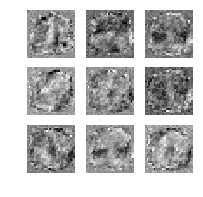

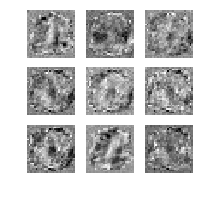

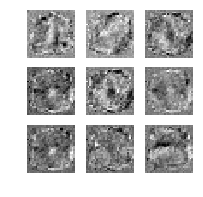

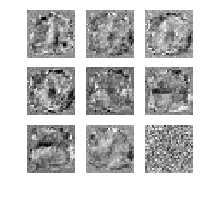

In [31]:
n_row = 3
n_col = 3
for i in range(1, 4+1):
    plt.figure(figsize=(n_row, n_col))
    for j in range(int(n_row*n_col)):
        plt.subplot(n_row, n_col, j+1)
        plt.imshow(van_mlp.l1.W.data[int(i*j)].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

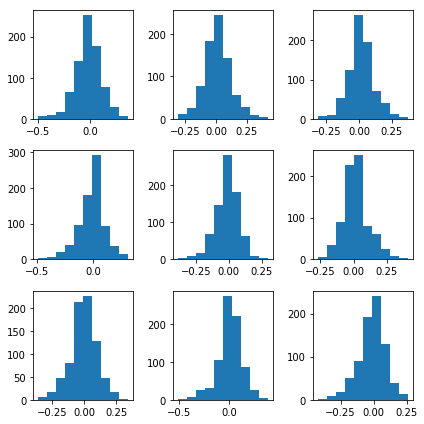

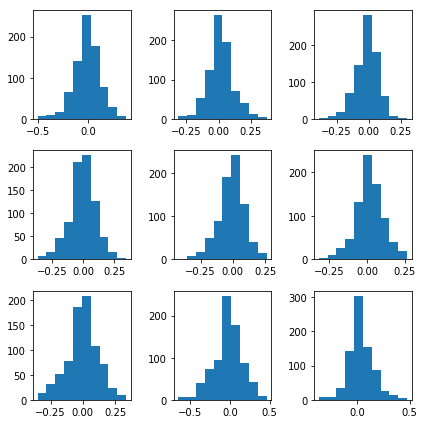

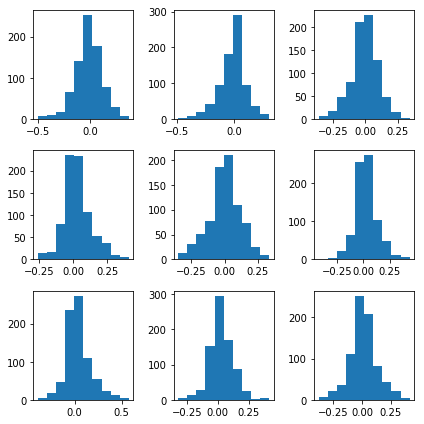

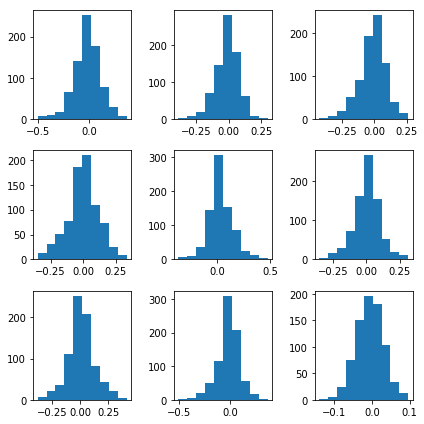

In [32]:
n_row = 3
n_col = 3
for i in range(1, 4+1):
    plt.figure(figsize=(n_row*2, n_col*2))
    for j in range(int(n_row*n_col)):
        plt.subplot(n_row, n_col, j+1)
#         plt.imshow(van_mlp.l1.W.data[int(i*j)].reshape(28, 28), cmap='gray')
        plt.hist(van_mlp.l1.W.data[int(i*j)])
#         plt.axis('off')
    plt.tight_layout()
    plt.show()

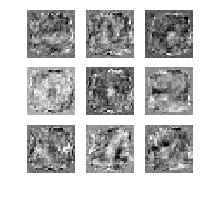

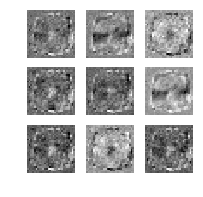

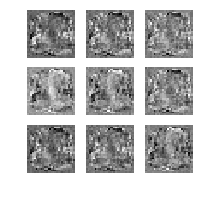

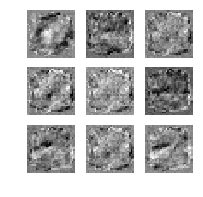

In [33]:
n_row = 3
n_col = 3
for i in range(1, 4+1):
    plt.figure(figsize=(n_row, n_col))
    for j in range(int(n_row*n_col)):
        plt.subplot(n_row, n_col, j+1)
        plt.imshow(sep_mlp.l1[i-1].W.data[int(j)].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

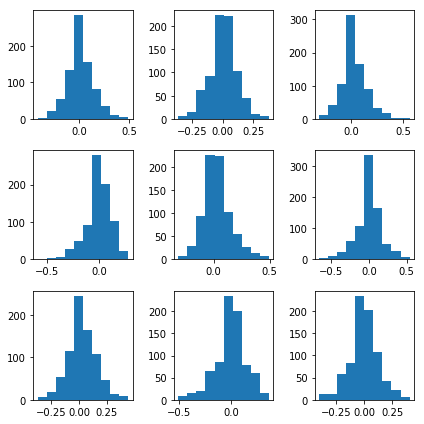

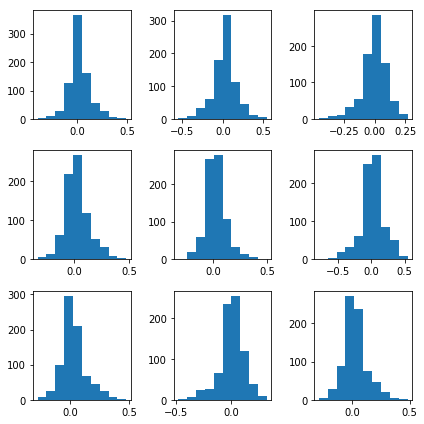

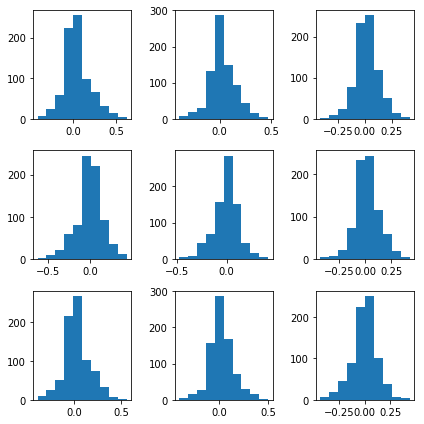

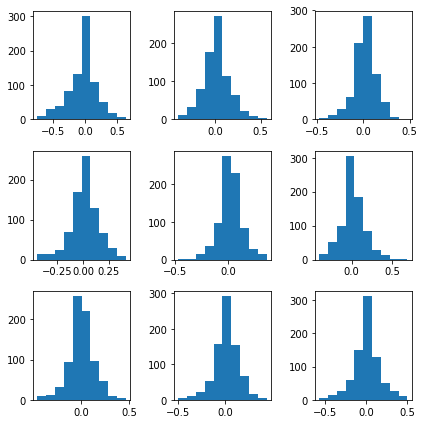

In [34]:
n_row = 3
n_col = 3
for i in range(1, 4+1):
    plt.figure(figsize=(n_row*2, n_col*2))
    for j in range(int(n_row*n_col)):
        plt.subplot(n_row, n_col, j+1)
#         plt.imshow(van_mlp.l1.W.data[int(i*j)].reshape(28, 28), cmap='gray')
        plt.hist(sep_mlp.l1[i-1].W.data[int(j)])
#         plt.axis('off')
    plt.tight_layout()
    plt.show()

[[-0.6383711  -0.73701066 -0.70972383  0.14730848  0.34879518 -0.44717187
   0.3044139  -1.0437025   0.23407768 -0.573597    0.24283293  0.65013105
   0.22678874  0.10064296 -0.37529677 -0.59007716  0.14288937  0.21120514
  -0.243859    0.48423433 -0.4442806  -0.00399336 -1.0481339   0.11020696
  -0.54983586  0.15763533 -0.2638852   0.421232    0.16978191 -0.27094623
   0.3843579  -0.7434633  -0.16349821 -1.0405079   0.5218868   0.76596624]
 [ 0.91754454 -0.09705126  0.23005874  0.19518319  0.18810716  0.20155774
  -0.51087964  0.6512295  -0.6811457   0.15718916 -0.34895095 -1.1829629
  -0.3951027  -0.5813118   0.93892777  0.21257801 -0.21678436 -0.4276126
   0.18142602  0.5423888  -0.21526016 -0.42549804  0.1999833   0.5016907
  -0.36729535 -0.18380298 -0.44005242  0.4804519   0.34409812  0.08182997
  -0.36050564 -0.31415105  0.33931968 -0.2693852  -0.5610664   0.8689793 ]
 [-0.43608466  0.5924013   0.02158475 -0.58335286 -0.4624772  -0.02419366
   0.10406875  0.02467263 -0.0342983   

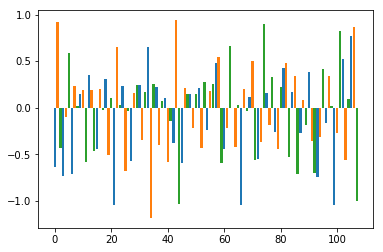

In [36]:
print(van_mlp.out.W.data)
plt.figure(figsize=())
plt.bar(np.arange(len(van_mlp.out.W.data[0]))*3, van_mlp.out.W.data[0])
plt.bar(np.arange(len(van_mlp.out.W.data[0]))*3+1, van_mlp.out.W.data[1])
plt.bar(np.arange(len(van_mlp.out.W.data[0]))*3+2, van_mlp.out.W.data[2])
plt.show()

[[-0.7896216   0.07772019 -0.5528545   0.42306086 -0.43570852 -0.8710024
   0.3613207  -0.25161695  0.29202682 -0.44205114 -0.92537695  0.5859242
  -0.7202828  -0.598946   -1.0996227  -0.7765566   0.46733007 -0.51399463]]


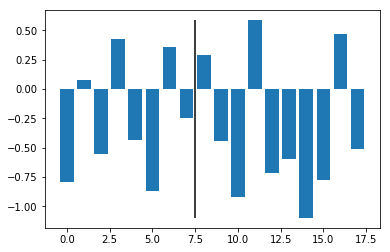

In [37]:
i = 0
print(sep_mlp.out[i].W.data)
plt.bar(np.arange(len(sep_mlp.out[i].W.data[0])), sep_mlp.out[i].W.data[0])
ymax = sep_mlp.out[i].W.data.max()
ymin = sep_mlp.out[i].W.data.min()
plt.vlines(n_col*n_row - 1.5 , ymin=ymin, ymax=ymax)
plt.show()

[[-0.53915447 -0.9736273   0.3827037  -1.1041083   0.38819262 -1.23532
  -0.5612522   0.9699687  -0.77520734 -0.33365437 -0.4673809  -0.5710264
   0.37270513  0.33989486 -0.4060895  -0.38241887 -0.78525954  0.36237776]]


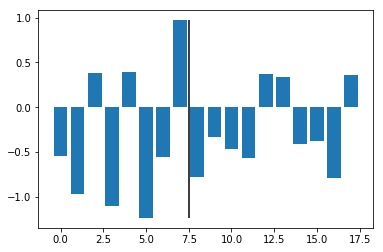

In [38]:
i = 1
print(sep_mlp.out[i].W.data)
plt.bar(np.arange(len(sep_mlp.out[i].W.data[0])), sep_mlp.out[i].W.data[0])
ymax = sep_mlp.out[i].W.data.max()
ymin = sep_mlp.out[i].W.data.min()
plt.vlines(n_col*n_row - 1.5 , ymin=ymin, ymax=ymax)
plt.show()

[[ 0.8384818   0.2587917   0.31046033 -0.23862037  0.07596757  1.0289156
   0.12225727 -1.2150028   0.97549593 -1.1141171   1.0758548  -0.2207922
  -0.30765358 -0.27769426  0.8504783   1.0246803  -0.21301067  1.0114964 ]]


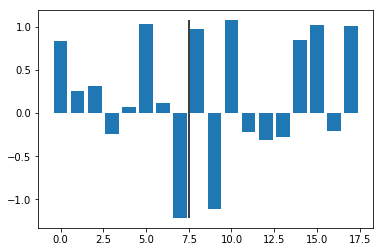

In [39]:
i = 2
print(sep_mlp.out[i].W.data)
plt.bar(np.arange(len(sep_mlp.out[i].W.data[0])), sep_mlp.out[i].W.data[0])
ymax = sep_mlp.out[i].W.data.max()
ymin = sep_mlp.out[i].W.data.min()
plt.vlines(n_col*n_row - 1.5 , ymin=ymin, ymax=ymax)
plt.show()

In [25]:
sep_mlp.out[1].W

variable W([[-8.095141  ,  0.09880515, -8.223263  , -0.09228643,
             -8.156168  , -7.5344877 , -6.94903   , -8.127547  ,
             -0.0091447 ,  1.1448834 ,  1.2463166 ,  1.2053225 ,
              1.3556124 ,  2.2839172 , -8.359102  ,  1.6433624 ,
              1.2620918 , -8.370325  ]])